## Inicialización del Notebook

### Instalar paquetes

In [1]:
# pip install pandas

In [2]:
# pip install matplotlib

In [3]:
# pip install wordcloud

In [4]:
# pip install nltk

In [5]:
# pip install xgboost

In [6]:
# pip install imblearn

### Imports

In [7]:
import pandas as pd
import numpy as np

import random

In [8]:
import string
import spacy
import nltk

from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [9]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

### Variables globales

In [13]:
# URL del archivo de tweets en Github
github_url = 'https://raw.githubusercontent.com/Vialesoft/Vialesoft_Devlab/refs/heads/main/Cursos/DataScienceIII/Proyecto_Final/test2.csv'

## Lectura

In [14]:
# Cargo el archivo en un DataFrame de Pandas
df_tweets = pd.read_csv(github_url)
df_original = df_tweets # Dataframe original de reserva

df_tweets.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km�),Density (P/Km�)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


## Análisis y limpieza del DataFrame

### Análisis primario

In [15]:
# Cantidad de filas
df_tweets.count()

textID              3534
text                3534
sentiment           3534
Time of Tweet       3534
Age of User         3534
Country             3534
Population -2020    3534
Land Area (Km�)     3534
Density (P/Km�)     3534
dtype: int64

In [16]:
# Información general del Dataframe
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km�)   3534 non-null   float64
 8   Density (P/Km�)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


In [17]:
# Revisamos valores nulos en las columnas
print(df_tweets.isnull().sum())

# Muchas filas completamente vacías (poco más de un tercio de las que si tienen información)

textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km�)     1281
Density (P/Km�)     1281
dtype: int64


In [18]:
# Buscamos tweets duplicados
df_tweets.duplicated().sum()

# Las filas duplicadas son las vacías

np.int64(1280)

In [19]:
# Cantidad de países diferentes

df_tweets["Country"].nunique()
df_tweets.Country.nunique()

195

In [20]:
# Cantidad de sentimientos positivos, negativos y neutros
# Datos extraídos a mano
print("Positivos")
print(df_tweets.loc[df_tweets["sentiment"] == "positive"]["text"].count())
print("Negativos")
print(df_tweets.loc[df_tweets["sentiment"] == "negative"]["text"].count())
print("Neutrales")
print(df_tweets.loc[df_tweets["sentiment"] == "neutral"]["text"].count())

Positivos
1103
Negativos
1001
Neutrales
1430


In [21]:
# Agrupando por sentimiento identificado
df_GroupbySentiment = df_tweets.groupby("sentiment")

print("Cantidad de sentimientos")
print(df_GroupbySentiment.ngroups)

print("Cantidad de tweets clasificados por sentimiento")
print(df_GroupbySentiment.size())

Cantidad de sentimientos
3
Cantidad de tweets clasificados por sentimiento
sentiment
negative    1001
neutral     1430
positive    1103
dtype: int64


In [22]:
df_GroupbySentiment.count()

,textID,text,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km�),Density (P/Km�)
sentiment,,,,,,,,
negative,1001,1001,1001,1001,1001,1001,1001,1001
neutral,1430,1430,1430,1430,1430,1430,1430,1430
positive,1103,1103,1103,1103,1103,1103,1103,1103


In [23]:
def classifyByCountry(dataframe, sentiment):
    df_Country = df_GroupbySentiment.get_group(sentiment).groupby("Country").size().to_frame().reset_index()
    df_Country = df_Country.set_axis(["Country", "Quantity"], axis=1)
    df_Country = df_Country.sort_values("Quantity", ascending=False)

    return df_Country

In [24]:
# Clasificación por país y sentimientos

df_NegativeCountry = classifyByCountry(df_GroupbySentiment, "negative")
df_PositiveCountry = classifyByCountry(df_GroupbySentiment, "positive")
df_NeutralCountry = classifyByCountry(df_GroupbySentiment, "neutral")

print("Negativo")
print(df_NegativeCountry.head())
print("Positivo")
print(df_PositiveCountry.head())
print("Neutral")
print(df_NeutralCountry.head())

Negativo
       Country  Quantity
19      Bhutan        13
114   Mongolia        11
18       Benin        10
99   Lithuania        10
63     Georgia        10
Positivo
                             Country  Quantity
43                     C�te d'Ivoire        12
44  Democratic Republic of the Congo        10
25                      Burkina Faso        10
24                          Bulgaria         9
6                          Argentina         9
Neutral
                        Country  Quantity
62                       Gambia        13
34                        Chile        12
46                      Denmark        12
60                       France        12
56  Eswatini (fmr. "Swaziland")        12


#### Nube de palabras

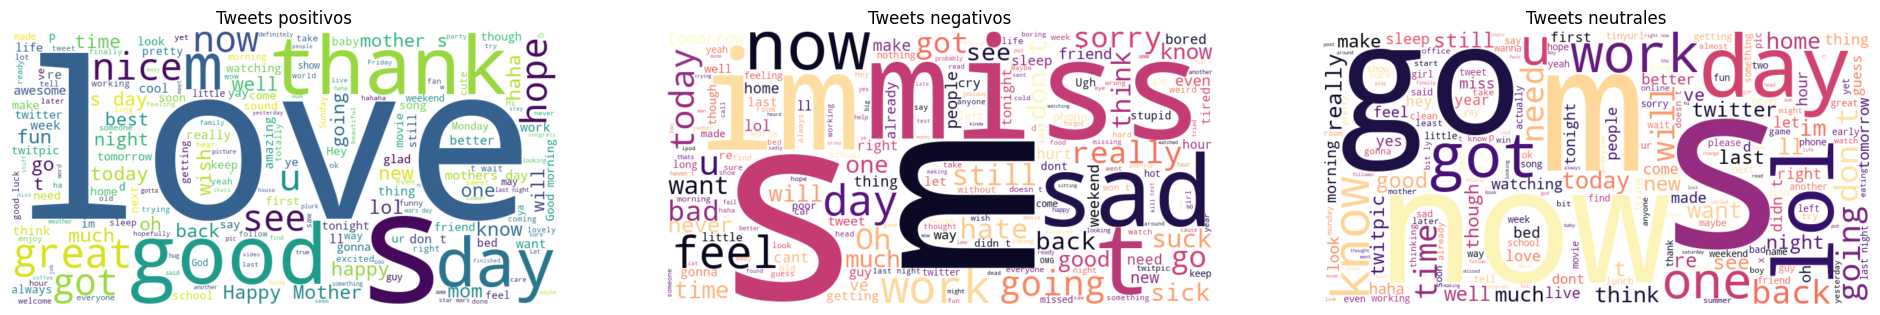

In [25]:
positive_twits = df_tweets[df_tweets['sentiment'] == 'positive']['text'].str.cat(sep=' ')
negative_twits = df_tweets[df_tweets['sentiment'] == 'negative']['text'].str.cat(sep=' ')
neutral_twits = df_tweets[df_tweets['sentiment'] == 'neutral']['text'].str.cat(sep=' ')

# Creando las wordclouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(positive_twits)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(negative_twits)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(neutral_twits)

plt.figure(figsize=(24, 12))

plt.subplot(1,3,1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tweets positivos', fontsize=12)

plt.subplot(1,3,2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tweets negativos', fontsize=12)

plt.subplot(1,3,3)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tweets neutrales', fontsize=12)

plt.show()

### Limpieza del Dataframe

#### Eliminación de columnas innecesarias

Se eliminarán todas las columnas que no vamos a utilizar

In [26]:
df_tweets = df_tweets[["text", "sentiment", "Time of Tweet", "Country"]]

df_tweets.head()

,text,sentiment,Time of Tweet,Country
0,Last session of the day http://twitpic.com/67ezh,neutral,morning,Afghanistan
1,Shanghai is also really exciting (precisely -...,positive,noon,Albania
2,"Recession hit Veronique Branquinho, she has to...",negative,night,Algeria
3,happy bday!,positive,morning,Andorra
4,http://twitpic.com/4w75p - I like it!!,positive,noon,Angola


#### Limpieza de valores nulos y duplicados

In [27]:
# Limpiamos valores nulos (y duplicados, al ser los duplicados solamente los nulos)
df_tweets = df_tweets.dropna()

In [28]:
# Chequeamos que no queden ni duplicados ni nulos
print (df_tweets.duplicated().sum())
print (df_tweets.isnull().sum())

0
text             0
sentiment        0
Time of Tweet    0
Country          0
dtype: int64


## Preprocesamiento

- 1: Convertir todo a minúsculas
- 2: Remover caracteres especiales *
- 3: Remover stopwords
- 4: Stemming y lemantización

### Eliminar sentimientos neutros

A modo de prueba, se intentará clasificar solo en negativos y positivos

In [29]:
df_tweets = df_tweets[df_tweets["sentiment"] != "neutral"]

df_tweets.head()

,text,sentiment,Time of Tweet,Country
1,Shanghai is also really exciting (precisely -...,positive,noon,Albania
2,"Recession hit Veronique Branquinho, she has to...",negative,night,Algeria
3,happy bday!,positive,morning,Andorra
4,http://twitpic.com/4w75p - I like it!!,positive,noon,Angola
5,that`s great!! weee!! visitors!,positive,night,Antigua and Barbuda


### Remover caracteres especiales*

La eliminación de caracteres especiales en este contexto no parece la mejor idea. En un tuit, las personas comparten links, enfatizan emociones a través de signos de exclamación e interrogación, e incluso mediante el uso de numerales al citar hashtags
Por este motivo, se decidió crear una nueva columna removiendo estos caracteres y, luego, generar un set de modelos con cada una de las columnas de texto, a fin de evaluar la precisión de cada uno cuando se remueven (o no) los caracteres especiales

In [30]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Por defecto

def preprocess(text, special_words = False):
    # Texto a minúsculas
    text = text.lower()
    
    # Tokenización
    words = nltk.word_tokenize(text)

    if(special_words):
        # Caracteres especiales
        words = [word for word in words if word not in string.punctuation]

    # Stop-Words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lematización
    lemmatizer = WordNetLemmatizer()
    pos_tags = pos_tag(words)
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    #words = [lemmatizer.lemmatize(word) for word in words]

    # Volvemos a juntar y retornamos el texto pre procesado
    return ' '.join(words)

In [31]:
list_tweets = df_tweets["text"].tolist()

In [32]:
list_tweets = [preprocess(tuit) for tuit in list_tweets]
df_tweets["text_Processed"] = list_tweets

## Separación en datos de Train y Test

Primero se vectorizarán los textos y se codificarán los sentimientos

En esta primera instancia, el conjunto de test será de un 30%


In [33]:
df_tweets.head()

,text,sentiment,Time of Tweet,Country,text_Processed
1,Shanghai is also really exciting (precisely -...,positive,noon,Albania,shanghai also really exciting ( precisely -- s...
2,"Recession hit Veronique Branquinho, she has to...",negative,night,Algeria,"recession hit veronique branquinho , quit comp..."
3,happy bday!,positive,morning,Andorra,happy bday !
4,http://twitpic.com/4w75p - I like it!!,positive,noon,Angola,http : //twitpic.com/4w75p - like ! !
5,that`s great!! weee!! visitors!,positive,night,Antigua and Barbuda,` great ! ! weee ! ! visitor !


In [34]:
y = df_tweets['sentiment']

In [35]:
X_tweets_text = df_tweets["text_Processed"]

In [36]:
# Separo en conjuntos de train y test
# Primero separaremos las X en conjuntos de train y test, para cada conjunto
# En esta primera instancia, el conjunto de test será de un 30%

X_train_tweets, X_test_tweets, y_train_tweets, y_test_tweets = train_test_split(X_tweets_text, y, test_size=0.3, random_state=42)

In [37]:
label_encoder = LabelEncoder()
y_train_tweets = label_encoder.fit_transform(y_train_tweets)
y_test_tweets = label_encoder.transform(y_test_tweets)

### Definimos una función para evaluar cada modelo

#### Evaluación del modelo

In [38]:
def train_model(model):
    '''clf = GridSearchCV(model["model"], model["params"], cv=5, scoring='f1_weighted') #scoring='f1_weighted, accuracy'
    clf.fit(X_train_tweets_vec, y_train_tweets)'''

    clf = GridSearchCV(model["pipeline"], model["param_grid"], cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
    clf.fit(X_train_tweets, y_train_tweets)
    
    best_model = clf.best_estimator_
    metrics = evaluate_model(best_model, X_test_tweets, y_test_tweets)

    ret = {
        'model': model["model"],
        'metrics': metrics,
        'best_model': best_model,
        'best_params': clf.best_params_
    }

    return ret

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted') # ,  weighted, micro, macro, None
    recall = recall_score(y_val, y_pred, average='weighted') # , average='weighted'
    f1 = f1_score(y_val, y_pred, average='weighted') #, average='weighted'
    confusion = confusion_matrix(y_val, y_pred)
    
    return {
        'accuracy': accuracy, 
        'precision': precision, 
        'recall': recall, 
        'f1': f1, 
        'confusion': confusion
    }

In [39]:
# Train y evaluate originales

'''def train_model(model):
    model_performance = {}
    clf = GridSearchCV(model["model"], model["params"], cv=5, scoring='f1_weighted') #scoring='f1_weighted, accuracy'
    clf.fit(X_train_tweets_vec, y_train_tweets)
    best_model = clf.best_estimator_
    
    metrics = evaluate_model(best_model, X_test_tweets_vec, y_test_tweets)
    model_performance[model["model"]] = metrics

    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1-Score: {metrics['f1']}")
    print(f"Confusion Matrix:\n{metrics['confusion']}")

    print(f"Mejores parámetros para {model["model"]}: {clf.best_params_}")

    return best_model

def evaluate_model(model, X_val, y_val):
    # model.fit(X_train, y_train) # Esto no es necesario si el modelo ya viene entrenado
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted') # ,  weighted, micro, macro, None
    recall = recall_score(y_val, y_pred, average='weighted') # , average='weighted'
    f1 = f1_score(y_val, y_pred, average='weighted') #, average='weighted'
    confusion = confusion_matrix(y_val, y_pred)
    
    return {
        'accuracy': accuracy, 
        'precision': precision, 
        'recall': recall, 
        'f1': f1, 
        'confusion': confusion
    }'''

'def train_model(model):\n    model_performance = {}\n    clf = GridSearchCV(model["model"], model["params"], cv=5, scoring=\'f1_weighted\') #scoring=\'f1_weighted, accuracy\'\n    clf.fit(X_train_tweets_vec, y_train_tweets)\n    best_model = clf.best_estimator_\n    \n    metrics = evaluate_model(best_model, X_test_tweets_vec, y_test_tweets)\n    model_performance[model["model"]] = metrics\n\n    print(f"Accuracy: {metrics[\'accuracy\']}")\n    print(f"Precision: {metrics[\'precision\']}")\n    print(f"Recall: {metrics[\'recall\']}")\n    print(f"F1-Score: {metrics[\'f1\']}")\n    print(f"Confusion Matrix:\n{metrics[\'confusion\']}")\n\n    print(f"Mejores parámetros para {model["model"]}: {clf.best_params_}")\n\n    return best_model\n\ndef evaluate_model(model, X_val, y_val):\n    # model.fit(X_train, y_train) # Esto no es necesario si el modelo ya viene entrenado\n    y_pred = model.predict(X_val)\n    accuracy = accuracy_score(y_val, y_pred)\n    precision = precision_score(y_val,

#### Evaluación con calibración

In [40]:
def evaluate_model_calibrated(model, X_train, y_train, X_val, y_val):
    calibrated_nb = CalibratedClassifierCV(model, cv=5)
    calibrated_nb.fit(X_train, y_train)
    y_pred = calibrated_nb.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted') # ,  weighted, micro, macro, None
    recall = recall_score(y_val, y_pred, average='weighted') # , average='weighted'
    f1 = f1_score(y_val, y_pred, average='weighted') #, average='weighted'
    confusion = confusion_matrix(y_val, y_pred)
    
    return {
        'accuracy': accuracy, 
        'precision': precision, 
        'recall': recall, 
        'f1': f1, 
        'confusion': confusion
    }

## DeepLearning (Modelos pre existentes)

### Multinomial NB

#### Definición del modelo

In [101]:
'''var_model = {
    'model': MultinomialNB(),
    'params': {
        'alpha': [0.01, 0.1, 1, 10],
        'fit_prior': [True, False]
    }
}'''

var_model_Multinomial = {
    'model': 'MultinomialNB',
    'pipeline': Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('classifier', MultinomialNB())
    ]),
    'param_grid': {
        'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
        'vectorizer__min_df': [1, 3, 5],
        'vectorizer__max_df': [0.75, 0.9, 1.0],
        'vectorizer__sublinear_tf': [True, False],
        'vectorizer__stop_words': [None, 'english'],
        'classifier__alpha': [0.01, 0.1, 1, 10],
        'classifier__fit_prior': [True, False]
    }
}

#### Entrenamiento del modelo

In [102]:
best_models = []

In [103]:
best_model_Multinomial = train_model(var_model_Multinomial)
best_models.append(best_model_Multinomial)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


#### Resultados del mejor modelo

In [105]:
print(f"Accuracy: {best_model_Multinomial["metrics"]['accuracy']}")
print(f"Precision: {best_model_Multinomial["metrics"]['precision']}")
print(f"Recall: {best_model_Multinomial["metrics"]['recall']}")
print(f"F1-Score: {best_model_Multinomial["metrics"]['f1']}")
print('\n')
print(f"Confusion Matrix:\n{best_model_Multinomial["metrics"]['confusion']}")
print('\n')
print(f"Mejores parámetros para {best_model_Multinomial["model"]}:\n {best_model_Multinomial["best_params"]}")

Accuracy: 0.814873417721519
Precision: 0.8147618762879011
Recall: 0.814873417721519
F1-Score: 0.8147992018532783


Confusion Matrix:
[[231  60]
 [ 57 284]]


Mejores parámetros para MultinomialNB:
 {'classifier__alpha': 1, 'classifier__fit_prior': False, 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': None, 'vectorizer__sublinear_tf': True}


#### Entrenamiento del modelo calibrado

In [104]:
vectorizer_calibrado = TfidfVectorizer(
    stop_words=None,           # quitar palabras comunes
    ngram_range=(1,1),         # usar bigramas
    max_df=0.75,               # quitar palabras que aparecen en más del 75% de los textos
    min_df=3,                  # quitar palabras muy raras
    sublinear_tf=True,         # importante: log(1 + tf) en lugar de tf crudo
    norm=None                  # o probar sin normalizar: norm=None (norm='l2')
)

# Vectorizar primero y pasar esos conjuntos
X_train_tweets_vec_Calibrado = vectorizer_calibrado.fit_transform(X_train_tweets) # aprende el vocabulario y transforma
X_test_tweets_vec_Calibrado = vectorizer_calibrado.transform(X_test_tweets) # transforma usando el vocabulario ya aprendido

metrics_Calibrated = evaluate_model_calibrated(MultinomialNB(alpha=1, fit_prior=False), X_train_tweets_vec_Calibrado, y_train_tweets, X_test_tweets_vec_Calibrado, y_test_tweets)

print(f"Calibrated Accuracy: {metrics_Calibrated['accuracy']}")
print(f"Calibrated Precision: {metrics_Calibrated['precision']}")
print(f"Calibrated Recall: {metrics_Calibrated['recall']}")
print(f"Calibrated F1-Score: {metrics_Calibrated['f1']}")
print("\n")
print(f"Calibrated Confusion Matrix:\n{metrics_Calibrated['confusion']}")

Calibrated Accuracy: 0.7784810126582279
Calibrated Precision: 0.7810511474961754
Calibrated Recall: 0.7784810126582279
Calibrated F1-Score: 0.7788233157291754


Calibrated Confusion Matrix:
[[232  59]
 [ 81 260]]


### Logistic Regression

In [106]:
var_model_Logistic = {
    'model': 'LogisticRegression',
    'pipeline': Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('classifier', LogisticRegression(solver='liblinear', max_iter=1000))
    ]),
    'param_grid': {
        'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
        'vectorizer__min_df': [1, 3, 5],
        'vectorizer__max_df': [0.75, 0.9, 1.0],
        'vectorizer__sublinear_tf': [True, False],
        'vectorizer__stop_words': [None, 'english'],
        'classifier__C': [0.01, 0.1, 1],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__class_weight': ['balanced', None]
    }
}

In [107]:
best_model_Logistic = train_model(var_model_Logistic)
best_models.append(best_model_Logistic)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


#### Resultados del mejor modelo

In [108]:
print(f"Accuracy: {best_model_Logistic["metrics"]['accuracy']}")
print(f"Precision: {best_model_Logistic["metrics"]['precision']}")
print(f"Recall: {best_model_Logistic["metrics"]['recall']}")
print(f"F1-Score: {best_model_Logistic["metrics"]['f1']}")
print('\n')
print(f"Confusion Matrix:\n{best_model_Logistic["metrics"]['confusion']}")
print('\n')
print(f"Mejores parámetros para {best_model_Logistic["model"]}:\n {best_model_Logistic["best_params"]}")

Accuracy: 0.8132911392405063
Precision: 0.8148434927954987
Recall: 0.8132911392405063
F1-Score: 0.813546167563779


Confusion Matrix:
[[240  51]
 [ 67 274]]


Mejores parámetros para LogisticRegression:
 {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': None, 'vectorizer__sublinear_tf': True}


#### Entrenamiento del modelo calibrado

In [110]:
vectorizer_calibrado = TfidfVectorizer(
    stop_words=None,           # quitar palabras comunes
    ngram_range=(1,1),         # usar bigramas
    max_df=0.75,               # quitar palabras que aparecen en más del 75% de los textos
    min_df=1,                  # quitar palabras muy raras
    sublinear_tf=True,         # importante: log(1 + tf) en lugar de tf crudo
    norm=None                  # o probar sin normalizar: norm=None (norm='l2')
)

# Vectorizar primero y pasar esos conjuntos
X_train_tweets_vec_Calibrado = vectorizer_calibrado.fit_transform(X_train_tweets) # aprende el vocabulario y transforma
X_test_tweets_vec_Calibrado = vectorizer_calibrado.transform(X_test_tweets) # transforma usando el vocabulario ya aprendido

metrics_Calibrated = evaluate_model_calibrated(LogisticRegression(C=1, class_weight=None, penalty='l2'), X_train_tweets_vec_Calibrado, y_train_tweets, X_test_tweets_vec_Calibrado, y_test_tweets)

print(f"Calibrated Accuracy: {metrics_Calibrated['accuracy']}")
print(f"Calibrated Precision: {metrics_Calibrated['precision']}")
print(f"Calibrated Recall: {metrics_Calibrated['recall']}")
print(f"Calibrated F1-Score: {metrics_Calibrated['f1']}")
print("\n")
print(f"Calibrated Confusion Matrix:\n{metrics_Calibrated['confusion']}")

Calibrated Accuracy: 0.8022151898734177
Calibrated Precision: 0.8039327497397117
Calibrated Recall: 0.8022151898734177
Calibrated F1-Score: 0.8024937425451162


Calibrated Confusion Matrix:
[[237  54]
 [ 71 270]]


### Random Forest Classifier

In [123]:
var_model_RandomForest = {
    'model': 'RandomForestClassifier',
    'pipeline': Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'param_grid': {
        'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
        'vectorizer__min_df': [1, 3, 5],
        'vectorizer__max_df': [0.75, 0.9, 1.0],
        'vectorizer__sublinear_tf': [True, False],
        # 'vectorizer__stop_words': [None, 'english'],
        'classifier__n_estimators': [100, 200, 300],        # Número de árboles en el bosque [100, 200, 300]
        'classifier__max_depth': [None, 10, 20, 30],         # Profundidad máxima del árbol [None, 10, 20, 30]
        'classifier__min_samples_split': [10],         # Mínimo de muestras para dividir un nodo [2, 5, 10]
        'classifier__min_samples_leaf': [1],           # Mínimo de muestras en una hoja [1, 2, 4]
        'classifier__max_features': ['sqrt', 'log2'],  # Número de features a considerar por división ['sqrt', 'log2', None]
        'classifier__bootstrap': [False]               # Si se hace muestreo con reemplazo [True, False]
    }
}

In [121]:
best_model_RandomForest = train_model(var_model_RandomForest)
best_models.append(best_model_RandomForest)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


#### Resultados del mejor modelo

In [122]:
print(f"Accuracy: {best_model_RandomForest["metrics"]['accuracy']}")
print(f"Precision: {best_model_RandomForest["metrics"]['precision']}")
print(f"Recall: {best_model_RandomForest["metrics"]['recall']}")
print(f"F1-Score: {best_model_RandomForest["metrics"]['f1']}")
print('\n')
print(f"Confusion Matrix:\n{best_model_RandomForest["metrics"]['confusion']}")
print('\n')
print(f"Mejores parámetros para {best_model_RandomForest["model"]}:\n {best_model_RandomForest["best_params"]}")

Accuracy: 0.8180379746835443
Precision: 0.8194393370456826
Recall: 0.8180379746835443
F1-Score: 0.8182778800155294


Confusion Matrix:
[[241  50]
 [ 65 276]]


Mejores parámetros para RandomForestClassifier:
 {'classifier__bootstrap': False, 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300, 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__sublinear_tf': False}


#### Entrenamiento del modelo calibrado

In [126]:
vectorizer_calibrado = TfidfVectorizer(
    ngram_range=(1,1),         # usar bigramas
    max_df=0.75,               # quitar palabras que aparecen en más del 75% de los textos
    min_df=1,                  # quitar palabras muy raras
    sublinear_tf=True,         # importante: log(1 + tf) en lugar de tf crudo
)

# Vectorizar primero y pasar esos conjuntos
X_train_tweets_vec_Calibrado = vectorizer_calibrado.fit_transform(X_train_tweets) # aprende el vocabulario y transforma
X_test_tweets_vec_Calibrado = vectorizer_calibrado.transform(X_test_tweets) # transforma usando el vocabulario ya aprendido

metrics_Calibrated = evaluate_model_calibrated(
    RandomForestClassifier(random_state=42, bootstrap=False, max_depth=30, max_features='sqrt', min_samples_leaf=1, min_samples_split=10, n_estimators=100),
    X_train_tweets_vec_Calibrado, y_train_tweets, X_test_tweets_vec_Calibrado, y_test_tweets)

print(f"Calibrated Accuracy: {metrics_Calibrated['accuracy']}")
print(f"Calibrated Precision: {metrics_Calibrated['precision']}")
print(f"Calibrated Recall: {metrics_Calibrated['recall']}")
print(f"Calibrated F1-Score: {metrics_Calibrated['f1']}")
print("\n")
print(f"Calibrated Confusion Matrix:\n{metrics_Calibrated['confusion']}")

Calibrated Accuracy: 0.8022151898734177
Calibrated Precision: 0.8076612313792488
Calibrated Recall: 0.8022151898734177
Calibrated F1-Score: 0.8024753033138734


Calibrated Confusion Matrix:
[[246  45]
 [ 80 261]]


### SVC (Support Vector Classifier)

In [128]:
var_model_SVC = {
    'model': 'SVC',
    'pipeline': Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('classifier', SVC())
    ]),
    'param_grid': {
        'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
        'vectorizer__min_df': [1, 3, 5],
        'vectorizer__max_df': [0.75, 0.9, 1.0],
        'vectorizer__sublinear_tf': [True, False],
        'vectorizer__stop_words': [None, 'english'],
        'classifier__C': [0.01, 0.1, 1, 10],            # Regularización: menor C = margen más amplio
        'classifier__kernel': ['rbf'],                  # Tipo de núcleo (linear suele funcionar bien con texto) ['linear', 'rbf']
        'classifier__gamma': ['scale', 'auto'],         # Solo para 'rbf': controla la influencia de cada muestra
        'classifier__class_weight': [None, 'balanced']  # Para clases desbalanceadas
    }
}

In [129]:
best_model_SVC = train_model(var_model_SVC)
best_models.append(best_model_SVC)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


#### Resultados del mejor modelo

In [130]:
print(f"Accuracy: {best_model_SVC["metrics"]['accuracy']}")
print(f"Precision: {best_model_SVC["metrics"]['precision']}")
print(f"Recall: {best_model_SVC["metrics"]['recall']}")
print(f"F1-Score: {best_model_SVC["metrics"]['f1']}")
print('\n')
print(f"Confusion Matrix:\n{best_model_SVC["metrics"]['confusion']}")
print('\n')
print(f"Mejores parámetros para {best_model_SVC["model"]}:\n {best_model_SVC["best_params"]}")

Accuracy: 0.8212025316455697
Precision: 0.8218676605154795
Recall: 0.8212025316455697
F1-Score: 0.8213684082689741


Confusion Matrix:
[[239  52]
 [ 61 280]]


Mejores parámetros para SVC:
 {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': None, 'vectorizer__sublinear_tf': True}


#### Entrenamiento del modelo calibrado

In [132]:
vectorizer_calibrado = TfidfVectorizer(
    ngram_range=(1,1),         # usar bigramas
    max_df=0.75,               # quitar palabras que aparecen en más del 75% de los textos
    min_df=1,                  # quitar palabras muy raras
    sublinear_tf=True,         # importante: log(1 + tf) en lugar de tf crudo
)

# Vectorizar primero y pasar esos conjuntos
X_train_tweets_vec_Calibrado = vectorizer_calibrado.fit_transform(X_train_tweets) # aprende el vocabulario y transforma
X_test_tweets_vec_Calibrado = vectorizer_calibrado.transform(X_test_tweets) # transforma usando el vocabulario ya aprendido

metrics_Calibrated = evaluate_model_calibrated(
    SVC(C=1, class_weight=None, gamma='scale', kernel='rbf'),
    X_train_tweets_vec_Calibrado, y_train_tweets, X_test_tweets_vec_Calibrado, y_test_tweets)

print(f"Calibrated Accuracy: {metrics_Calibrated['accuracy']}")
print(f"Calibrated Precision: {metrics_Calibrated['precision']}")
print(f"Calibrated Recall: {metrics_Calibrated['recall']}")
print(f"Calibrated F1-Score: {metrics_Calibrated['f1']}")
print("\n")
print(f"Calibrated Confusion Matrix:\n{metrics_Calibrated['confusion']}")

Calibrated Accuracy: 0.8212025316455697
Calibrated Precision: 0.822085883141923
Calibrated Recall: 0.8212025316455697
Calibrated F1-Score: 0.8213953025317505


Calibrated Confusion Matrix:
[[240  51]
 [ 62 279]]


### K Neighbors Classifier

In [133]:
var_model_KNeighborsClassifier = {
    'model': 'KNeighborsClassifier',
    'pipeline': Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('classifier', KNeighborsClassifier())
    ]),
    'param_grid': {
        'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
        'vectorizer__min_df': [1, 3, 5],
        'vectorizer__max_df': [0.75, 0.9, 1.0],
        'vectorizer__sublinear_tf': [True, False],
        'vectorizer__stop_words': [None, 'english'],
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__weights': ['uniform', 'distance'],  # Ponderar todos igual o según distancia
        'classifier__metric': ['euclidean', 'manhattan', 'cosine']  # Distancia a usar
    }
}

In [134]:
best_model_KNeighborsClassifier = train_model(var_model_KNeighborsClassifier)
best_models.append(best_model_KNeighborsClassifier)

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


#### Resultados del mejor modelo

In [135]:
print(f"Accuracy: {best_model_KNeighborsClassifier["metrics"]['accuracy']}")
print(f"Precision: {best_model_KNeighborsClassifier["metrics"]['precision']}")
print(f"Recall: {best_model_KNeighborsClassifier["metrics"]['recall']}")
print(f"F1-Score: {best_model_KNeighborsClassifier["metrics"]['f1']}")
print('\n')
print(f"Confusion Matrix:\n{best_model_KNeighborsClassifier["metrics"]['confusion']}")
print('\n')
print(f"Mejores parámetros para {best_model_KNeighborsClassifier["model"]}:\n {best_model_KNeighborsClassifier["best_params"]}")

Accuracy: 0.7753164556962026
Precision: 0.7752938126702351
Recall: 0.7753164556962026
F1-Score: 0.7745191481508433


Confusion Matrix:
[[210  81]
 [ 61 280]]


Mejores parámetros para KNeighborsClassifier:
 {'classifier__metric': 'cosine', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 3), 'vectorizer__stop_words': None, 'vectorizer__sublinear_tf': True}


#### Entrenamiento del modelo calibrado

In [137]:
vectorizer_calibrado = TfidfVectorizer(
    ngram_range=(1,3),         # usar bigramas
    max_df=0.75,               # quitar palabras que aparecen en más del 75% de los textos
    min_df=1,                  # quitar palabras muy raras
    sublinear_tf=True,         # importante: log(1 + tf) en lugar de tf crudo
)

# Vectorizar primero y pasar esos conjuntos
X_train_tweets_vec_Calibrado = vectorizer_calibrado.fit_transform(X_train_tweets) # aprende el vocabulario y transforma
X_test_tweets_vec_Calibrado = vectorizer_calibrado.transform(X_test_tweets) # transforma usando el vocabulario ya aprendido

metrics_Calibrated = evaluate_model_calibrated(
    KNeighborsClassifier(metric='cosine', n_neighbors=9, weights='distance'),
    X_train_tweets_vec_Calibrado, y_train_tweets, X_test_tweets_vec_Calibrado, y_test_tweets)

print(f"Calibrated Accuracy: {metrics_Calibrated['accuracy']}")
print(f"Calibrated Precision: {metrics_Calibrated['precision']}")
print(f"Calibrated Recall: {metrics_Calibrated['recall']}")
print(f"Calibrated F1-Score: {metrics_Calibrated['f1']}")
print("\n")
print(f"Calibrated Confusion Matrix:\n{metrics_Calibrated['confusion']}")

Calibrated Accuracy: 0.7879746835443038
Calibrated Precision: 0.7883985328440268
Calibrated Recall: 0.7879746835443038
Calibrated F1-Score: 0.7881155046094537


Calibrated Confusion Matrix:
[[227  64]
 [ 70 271]]


### XGB Classifier

In [142]:
var_model_XGBClassifier = {
    'model': 'XGBClassifier',
    'pipeline': Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('classifier', XGBClassifier())
    ]),
    'param_grid': {
        'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
        'vectorizer__min_df': [1, 3, 5],
        'vectorizer__max_df': [0.75, 0.9, 1.0],
        'vectorizer__sublinear_tf': [True, False],
        'vectorizer__stop_words': [None, 'english'],
        'classifier__learning_rate': [0.1, 0.01],
        'classifier__max_depth': [3, 5, 7],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.3],
        'classifier__subsample': [0.7, 1.0],
        'classifier__colsample_bytree': [0.7, 1.0],
        'classifier__gamma': [0, 1],
        'classifier__reg_lambda': [1, 10],  # regularización L2
        'classifier__reg_alpha': [0, 1],     # regularización L1
    }
}

In [143]:
best_model_XGBClassifier = train_model(var_model_XGBClassifier)
best_models.append(best_model_XGBClassifier)

Fitting 5 folds for each of 62208 candidates, totalling 311040 fits


KeyboardInterrupt: 

#### Resultados del mejor modelo

In [ ]:
print(f"Accuracy: {best_model_XGBClassifier["metrics"]['accuracy']}")
print(f"Precision: {best_model_XGBClassifier["metrics"]['precision']}")
print(f"Recall: {best_model_XGBClassifier["metrics"]['recall']}")
print(f"F1-Score: {best_model_XGBClassifier["metrics"]['f1']}")
print('\n')
print(f"Confusion Matrix:\n{best_model_XGBClassifier["metrics"]['confusion']}")
print('\n')
print(f"Mejores parámetros para {best_model_XGBClassifier["model"]}:\n {best_model_XGBClassifier["best_params"]}")

#### Entrenamiento del modelo calibrado

In [ ]:
vectorizer_calibrado = TfidfVectorizer(
    stop_words=None,           # quitar palabras comunes
    ngram_range=(1,1),         # usar bigramas
    max_df=0.75,               # quitar palabras que aparecen en más del 75% de los textos
    min_df=1,                  # quitar palabras muy raras
    sublinear_tf=True,         # importante: log(1 + tf) en lugar de tf crudo
    norm=None                  # o probar sin normalizar: norm=None (norm='l2')
)

# Vectorizar primero y pasar esos conjuntos
X_train_tweets_vec_Calibrado = vectorizer_calibrado.fit_transform(X_train_tweets) # aprende el vocabulario y transforma
X_test_tweets_vec_Calibrado = vectorizer_calibrado.transform(X_test_tweets) # transforma usando el vocabulario ya aprendido

metrics_Calibrated = evaluate_model_calibrated(MultinomialNB(C=1, class_weight=None, penalty='l2'), X_train_tweets_vec_Calibrado, y_train_tweets, X_test_tweets_vec_Calibrado, y_test_tweets)

print(f"Calibrated Accuracy: {metrics_Calibrated['accuracy']}")
print(f"Calibrated Precision: {metrics_Calibrated['precision']}")
print(f"Calibrated Recall: {metrics_Calibrated['recall']}")
print(f"Calibrated F1-Score: {metrics_Calibrated['f1']}")
print("\n")
print(f"Calibrated Confusion Matrix:\n{metrics_Calibrated['confusion']}")

In [148]:
for i in best_models:
    print("--------")
    print(f"Model: {i["model"]}")
    print("--------")
    print(f"Accuracy: {i["metrics"]["accuracy"]}")
    print(f"Precision: {i["metrics"]["precision"]}")
    print(f"Recall: {i["metrics"]["recall"]}")
    print(f"F1: {i["metrics"]["f1"]}")
    print(f"Confusion:\n {i["metrics"]["confusion"]}")

--------
Model: MultinomialNB
--------
Accuracy: 0.814873417721519
Precision: 0.8147618762879011
Recall: 0.814873417721519
F1: 0.8147992018532783
Confusion:
 [[231  60]
 [ 57 284]]
--------
Model: LogisticRegression
--------
Accuracy: 0.8132911392405063
Precision: 0.8148434927954987
Recall: 0.8132911392405063
F1: 0.813546167563779
Confusion:
 [[240  51]
 [ 67 274]]
--------
Model: RandomForestClassifier
--------
Accuracy: 0.814873417721519
Precision: 0.8198400140646976
Recall: 0.814873417721519
F1: 0.8151336204415467
Confusion:
 [[249  42]
 [ 75 266]]
--------
Model: RandomForestClassifier
--------
Accuracy: 0.8180379746835443
Precision: 0.8194393370456826
Recall: 0.8180379746835443
F1: 0.8182778800155294
Confusion:
 [[241  50]
 [ 65 276]]
--------
Model: SVC
--------
Accuracy: 0.8212025316455697
Precision: 0.8218676605154795
Recall: 0.8212025316455697
F1: 0.8213684082689741
Confusion:
 [[239  52]
 [ 61 280]]
--------
Model: KNeighborsClassifier
--------
Accuracy: 0.7753164556962026
Pr

## DeepLearning (Modelo nuevo)

In [84]:
vectorizer = TfidfVectorizer(
    stop_words='english',           # quitar palabras comunes
    ngram_range=(1,2),         # usar bigramas
    max_df=0.8,               # quitar palabras que aparecen en más del 75% de los textos
    min_df=2,                  # quitar palabras muy raras
    sublinear_tf=True,         # importante: log(1 + tf) en lugar de tf crudo
    norm='l2'                  # o probar sin normalizar: norm=None (norm='l2')
)

In [85]:
# Vectorizar primero y pasar esos conjuntos
X_train_tweets_vec = vectorizer.fit_transform(X_train_tweets) # aprende el vocabulario y transforma
X_test_tweets_vec = vectorizer.transform(X_test_tweets) # transforma usando el vocabulario ya aprendido

In [91]:
X_train_tweets_vec

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7589 stored elements and shape (1472, 1304)>

In [116]:
from tensorflow.keras.regularizers import l2
dropout=0.2
l2_kernelregularizer = (1e-4)

# Convolutional neural network construction
model = keras.Sequential([
    layers.LayerNormalization(),
    layers.Dense(512, kernel_regularizer=l2(l2_kernelregularizer)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(dropout),
    layers.Dense(256, kernel_regularizer=l2(l2_kernelregularizer)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(dropout),
    layers.Dense(128, kernel_regularizer=l2(l2_kernelregularizer)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(dropout),
    layers.Dense(64, kernel_regularizer=l2(l2_kernelregularizer)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(dropout),
    layers.Dense(32, kernel_regularizer=l2(l2_kernelregularizer)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(dropout),
    layers.Dense(16, activation="relu", kernel_regularizer=l2(l2_kernelregularizer)),
    # Dense layer 1 neuron and ReLU activation (last layer)
    layers.Dense(1, activation="sigmoid"),
])

In [121]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
# Compile the model
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')])

# Adding EarlyStopping to avoid overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Model training
epochs = 30
batch_size = 64

model.fit(
    X_train_tweets_vec,
    y_train_tweets,
    validation_data=(X_test_tweets_vec, y_test_tweets),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall, auc = model.evaluate(X_test_tweets_vec, y_test_tweets)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9524 - auc: 0.9834 - loss: 0.3574 - precision_23: 0.9605 - recall_23: 0.9460 - val_accuracy: 0.7943 - val_auc: 0.8805 - val_loss: 0.5739 - val_precision_23: 0.8023 - val_recall_23: 0.8211
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9488 - auc: 0.9896 - loss: 0.3419 - precision_23: 0.9599 - recall_23: 0.9422 - val_accuracy: 0.8038 - val_auc: 0.8814 - val_loss: 0.5724 - val_precision_23: 0.8163 - val_recall_23: 0.8211
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9552 - auc: 0.9851 - loss: 0.3384 - precision_23: 0.9702 - recall_23: 0.9425 - val_accuracy: 0.8022 - val_auc: 0.8822 - val_loss: 0.5736 - val_precision_23: 0.8214 - val_recall_23: 0.8094
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9561 - auc: 0.9916 - loss: 0.3151 - precision_23: 0.9688 - recall_23: 0.9480 - val_accuracy: 0.8038 - val_auc: 0.8807 - val_loss: 0.5769 - val_precision_23: 0.8239 - val_recall

In [122]:
print(f"Loss: {test_loss}")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {auc}")

Loss: 0.5724239945411682
Accuracy: 0.8037974834442139
Precision: 0.8163265585899353
Recall: 0.8211143612861633
AUC: 0.8814483284950256


In [123]:
# Cálculo de la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = model.predict(X_test_tweets_vec)
y_pred_probs = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_test_tweets, y_pred_probs)

print(f"Confusion Matrix:\n {cm}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
Confusion Matrix:
 [[228  63]
 [ 61 280]]


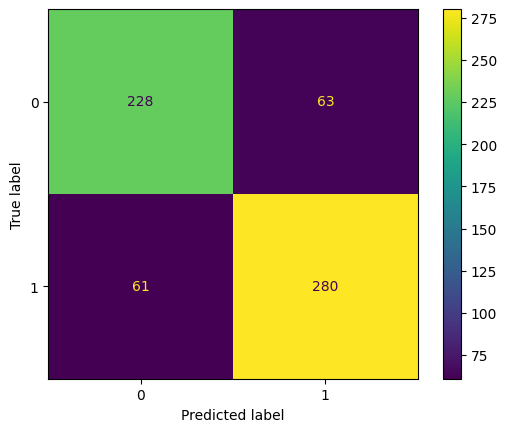

In [124]:
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [125]:
sample_tweets = ["I'm really happy, my son is five years old!.",
                  "I hate absolutely how the world is going",
                  "I think politics are being bad",
                  "I have gone to the best restaurant ever!!",
                  "I'm just OK",
                  "I think I will come back to Ushuaia next year! #Penguins",
                  "Bus tickets are so expensive! Goverment is really bad!",
                  "I have had the worst dining experience ever. The food was cold and the waiter was rude."]

In [127]:
sample_tweets_preprocessed = [preprocess(tweet) for tweet in sample_tweets]
sample_tweets_vectorized = vectorizer.transform(sample_tweets_preprocessed)
sample_tweets_predictions = model.predict(sample_tweets_vectorized)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [128]:
predicted_labels_formatted = [f"Positive ({prediction})" if prediction == 1 else f"Negative ({prediction})" for prediction in sample_tweets_predictions]

results = dict(zip(sample_tweets, predicted_labels_formatted))

for tweet, prediction in results.items():
    print(f"Tweet: {tweet}\nPrediction: {prediction}\n")

Tweet: I'm really happy, my son is five years old!.
Prediction: Negative ([0.40827265])

Tweet: I hate absolutely how the world is going
Prediction: Negative ([0.03422576])

Tweet: I think politics are being bad
Prediction: Negative ([0.09184742])

Tweet: I have gone to the best restaurant ever!!
Prediction: Negative ([0.83963597])

Tweet: I'm just OK
Prediction: Negative ([0.8300539])

Tweet: I think I will come back to Ushuaia next year! #Penguins
Prediction: Negative ([0.2554257])

Tweet: Bus tickets are so expensive! Goverment is really bad!
Prediction: Negative ([0.04455247])

Tweet: I have had the worst dining experience ever. The food was cold and the waiter was rude.
Prediction: Negative ([0.08614118])



La precisión del modelo parece buena, para los ejemplos inventados

Existe sin embargo cierto sesgo hacia el lado positivo (como en el caso de I'm just OK) que debería haberse catalogado quizá como neutral, de existir esta tercera categoría

En las siguientes pruebas, tomaremos 100 tweets random del set y probaremos el modelo con ellos

In [129]:
def get_random_tweets(list_tweets, num_tweets=10):
  random_indices = random.sample(range(len(list_tweets)), num_tweets)
  random_tweets = [list_tweets[i] for i in random_indices]
  return random_tweets

In [130]:
random_tweets = get_random_tweets(list_tweets, 100)

random_tweets_preprocessed = [preprocess(tweet) for tweet in random_tweets]
random_tweets_vectorized = vectorizer.transform(random_tweets_preprocessed)
random_predictions = model.predict(random_tweets_vectorized)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [131]:
random_predicted_labels_formatted = [f"Positive ({prediction})" if prediction == 1 else f"Negative ({prediction})" for prediction in random_predictions]
random_results = dict(zip(random_tweets, random_predicted_labels_formatted))

for tweet, prediction in random_results.items():
    print(f"Tuit: {tweet}\nPrediction: {prediction}\n")

Tuit: well tell fashion tip need ` woman hehehe
Prediction: Negative ([0.96558005])

Tuit: ian go matinee tomorrow , ` plan least ... ` go expensive 3d night
Prediction: Negative ([0.03301757])

Tuit: month leave high school ! thank god . ready summer
Prediction: Negative ([0.9405981])

Tuit: thanks gorgeous flower .
Prediction: Negative ([0.9910166])

Tuit: ( : 'your joint w/ crazy ! ! ' ) thx hey trax heard 49er rear end ? ?
Prediction: Negative ([0.86038643])

Tuit: disappointed talent lineup 'reventï¿½n super estrella 2009 ' ... hmm ... feeling ` get tix time around .
Prediction: Negative ([0.35823753])

Tuit: yes , would love cowbell !
Prediction: Negative ([0.97659564])

Tuit: happy mother day ! ! !
Prediction: Negative ([0.9921461])

Tuit: ` welcome . ! add already !
Prediction: Negative ([0.87273777])

Tuit: need motivation life , oh love would nice
Prediction: Negative ([0.97990483])

Tuit: anyone else see ? dm notification email say 'reply web . ' cool accent , ` weird online

La precisión de los tuits elegidos al azar parece buena en términos generales. Sin embargo, tiene algunos errores, propios de un modelo con una precisión de apenas sobre 80%